In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string as st 
import re

import nltk
from nltk import PorterStemmer, WordNetLemmatizer

import seaborn as sns
import itertools
import pickle
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

import gensim

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model

from IPython.display import HTML
from flask import Flask, render_template, request
from flask_cors import CORS

In [2]:
#Read and store the files
Fake_news_data = pd.read_csv('WELFake_Dataset.csv')

In [3]:
Fake_news_data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [4]:
Fake_news_data.tail()

,Unnamed: 0,title,text,label
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0
72133,72133,Goldman Sachs Endorses Hillary Clinton For Pre...,Goldman Sachs Endorses Hillary Clinton For Pre...,1


In [5]:
df = Fake_news_data
#Changing 0 to 'REAL' and 1 to 'FAKE'
df['label'] = df['label'].replace({0: 'REAL', 1:'FAKE'})
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,FAKE
1,1,NaN,Did they post their votes for Hillary already?,FAKE
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",FAKE
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,REAL
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",FAKE


In [6]:
#Checking how the lables are distributed
df['label'].value_counts()

label
FAKE    37106
REAL    35028
Name: count, dtype: int64

## Data Cleaning

In [7]:
#Removing all punctuations
def remove_punctuation(text):
    if isinstance(text, str):
        return "".join([ch for ch in text if ch not in st.punctuation])
    else:
        return ""

In [8]:
df['new_text'] = df['text'].apply(lambda x: remove_punctuation(x))
df.head()

,Unnamed: 0,title,text,label,new_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,FAKE,No comment is expected from Barack Obama Membe...
1,1,NaN,Did they post their votes for Hillary already?,FAKE,Did they post their votes for Hillary already
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",FAKE,Now most of the demonstrators gathered last n...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,REAL,A dozen politically active pastors came here f...
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",FAKE,The RS28 Sarmat missile dubbed Satan 2 will re...


In [9]:
#Converting text to lowercase, Split() applied for white space
def tokenize(text):
    text = re.split('\s+', text)
    return [x.lower() for x in text]

In [10]:
df['new_text'] = df['new_text'].apply(lambda msg:tokenize(msg))
df.head()

,Unnamed: 0,title,text,label,new_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,FAKE,"[no, comment, is, expected, from, barack, obam..."
1,1,NaN,Did they post their votes for Hillary already?,FAKE,"[did, they, post, their, votes, for, hillary, ..."
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",FAKE,"[, now, most, of, the, demonstrators, gathered..."
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,REAL,"[a, dozen, politically, active, pastors, came,..."
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",FAKE,"[the, rs28, sarmat, missile, dubbed, satan, 2,..."


In [11]:
#Removing of tokens less than length of 2
def remove_sml_words(text):
    return [x for x in text if len(x)>2]

In [12]:
df['new_text'] = df['new_text'].apply(lambda x: remove_sml_words(x))
df.head()

,Unnamed: 0,title,text,label,new_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,FAKE,"[comment, expected, from, barack, obama, membe..."
1,1,NaN,Did they post their votes for Hillary already?,FAKE,"[did, they, post, their, votes, for, hillary, ..."
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",FAKE,"[now, most, the, demonstrators, gathered, last..."
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,REAL,"[dozen, politically, active, pastors, came, he..."
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",FAKE,"[the, rs28, sarmat, missile, dubbed, satan, wi..."


In [13]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Samuel
[nltk_data]     Tong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 

In [14]:
#Removing of stopwords
def remove_stopword(text):
    stop_words = set(stopwords.words('english'))
    return[word for word in text if word not in stop_words]

In [15]:
df['new_text'] = df['new_text'].apply(lambda x: remove_stopword(x))
df.head()

,Unnamed: 0,title,text,label,new_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,FAKE,"[comment, expected, barack, obama, members, fy..."
1,1,NaN,Did they post their votes for Hillary already?,FAKE,"[post, votes, hillary, already]"
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",FAKE,"[demonstrators, gathered, last, night, exercis..."
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,REAL,"[dozen, politically, active, pastors, came, pr..."
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",FAKE,"[rs28, sarmat, missile, dubbed, satan, replace..."


In [16]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Samuel
[nltk_data]     Tong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
# Lemmetization of text data
def lemmatizer(text):
    word_net = WordNetLemmatizer()
    return[word_net.lemmatize(word) for word in text]

In [18]:
df['new_text'] = df['new_text'].apply(lambda x: lemmatizer(x))
df.head(10)

,Unnamed: 0,title,text,label,new_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,FAKE,"[comment, expected, barack, obama, member, fyf..."
1,1,NaN,Did they post their votes for Hillary already?,FAKE,"[post, vote, hillary, already]"
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",FAKE,"[demonstrator, gathered, last, night, exercisi..."
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,REAL,"[dozen, politically, active, pastor, came, pri..."
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",FAKE,"[rs28, sarmat, missile, dubbed, satan, replace..."
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,FAKE,"[say, one, time, someone, sued, southern, pove..."
6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,FAKE,"[ben, carson, tell, story, happened, spoke, ob..."
7,7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,FAKE,[]
8,8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",FAKE,"[owner, ringling, bar, located, south, white, ..."
9,9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",FAKE,"[file, sept, 2005, file, photo, marker, welcom..."


In [19]:
# Creating sentences to get clean text as input for vectors
def return_sentences(tokens):
    return " ".join([word for word in tokens])

In [20]:
df['new_text'] = df['new_text'].apply(lambda x: return_sentences(x))
df.head()

,Unnamed: 0,title,text,label,new_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,FAKE,comment expected barack obama member fyf911 fu...
1,1,NaN,Did they post their votes for Hillary already?,FAKE,post vote hillary already
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",FAKE,demonstrator gathered last night exercising co...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,REAL,dozen politically active pastor came private d...
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",FAKE,rs28 sarmat missile dubbed satan replace ss18 ...


In [21]:
df.sample(10)

,Unnamed: 0,title,text,label,new_text
71625,71625,Memo To Congress: Bring Back Earmarks!,Written by Daniel McAdams Thursday November 17...,FAKE,written daniel mcadams thursday november 2016 ...
51988,51988,U.S. militia girds for trouble as presidential...,U.S. militia girds for trouble as presidential...,FAKE,militia girds trouble presidential election ne...
37206,37206,Trump spokesman to brief press on Thursday,(Reuters) - Donald Trump’s spokesman said his ...,REAL,reuters donald trump’s spokesman said team bri...
63764,63764,"Shooting Left 1 Dead, 5 Injured at Zodiac Park...","On November 1, 2016, at approximately 8:15 P.M...",FAKE,november 2016 approximately 815 cdt shooting o...
33279,33279,Was Martin Luther King Jr. A Republican? The ...,Conservatives and Republicans love to claim th...,FAKE,conservative republican love claim martin luth...
54822,54822,Was Gaddafi Right About JFK?,The late Libyan leader Muammar Gaddafi remarke...,FAKE,late libyan leader muammar gaddafi remarked de...
40194,40194,Banks spent record amounts on lobbying in rece...,(Reuters) - Banks and other financial companie...,REAL,reuters bank financial company expecting big b...
23760,23760,Syria Ceasefire Deal: A Cynical Ploy by Washin...,21st Century Wire says This latest diplomatic ...,FAKE,21st century wire say latest diplomatic develo...
51408,51408,"What’s Happening In Oregon Is TREASON, Our Fo...","What s happening in Oregon isn t, by any means...",FAKE,happening oregon mean act patriotism duty citi...
32112,32112,George Takei NAILS Republican Hypocrisy On Tr...,Donald Trump insists that he doesn t have to d...,FAKE,donald trump insists divest sell business empi...


## Generating Basic WordClouds for fake and real news

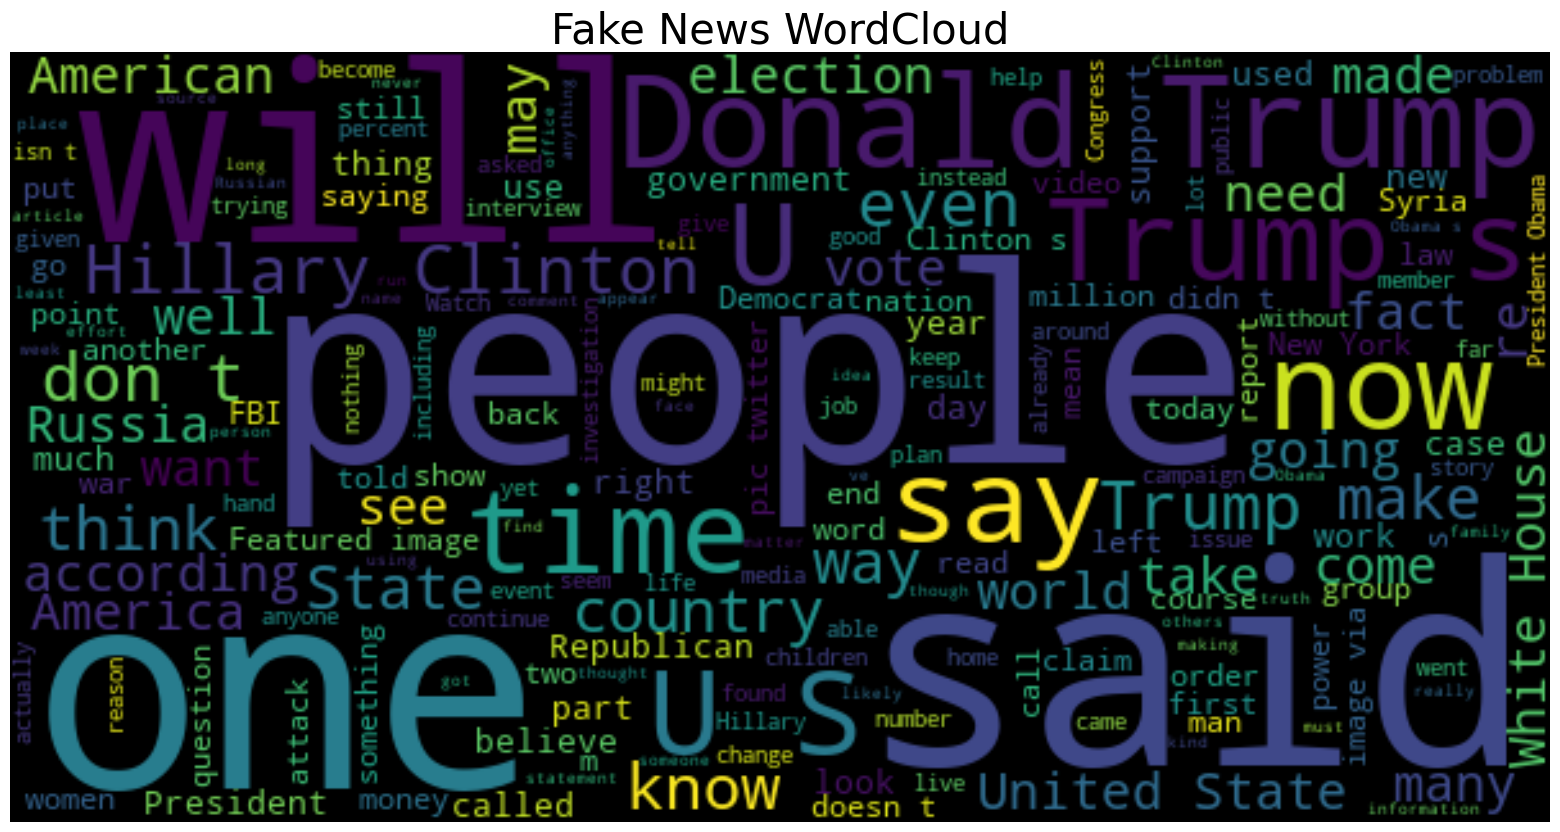

In [22]:
#Creating and generating a word cloud image from the fake news articles
fake_news_wc = df[df['label'] == 'FAKE'].copy()

fake_news_wc.loc[:, 'text'] = fake_news_wc['text'].astype(str).fillna('')

fake_text = ' '.join(fake_news_wc['text'])

wordcloud = WordCloud(width=600, height=300, random_state=21, max_font_size=110).generate(fake_text)
plt.figure(figsize= [20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Fake News WordCloud', fontsize = 30)
plt.show()

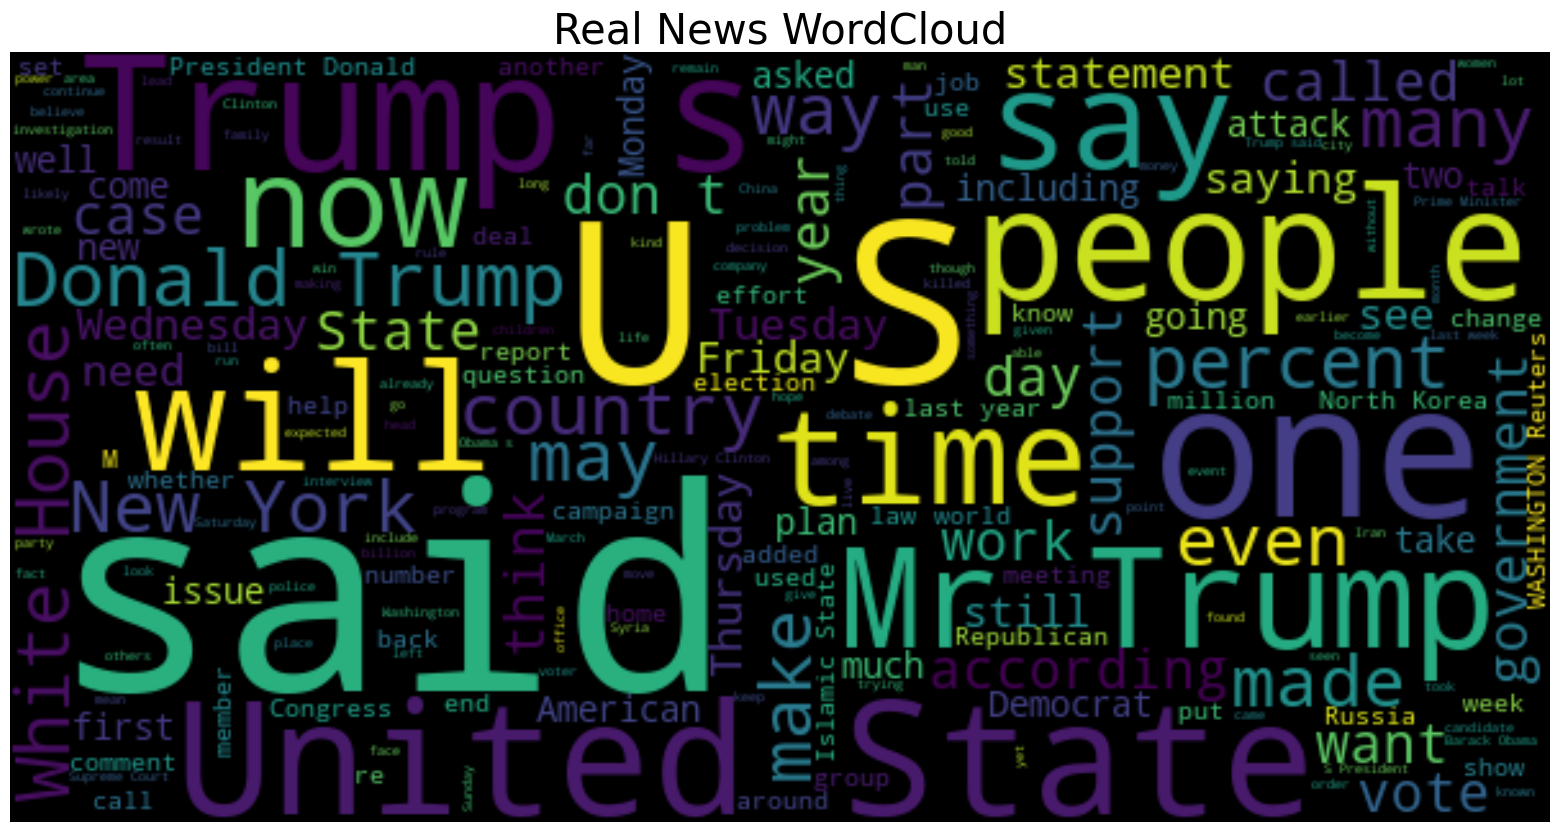

In [23]:
#Creating and generating a word cloud image from the real news articles
real_news_wc = df[df['label'] == 'REAL'].copy()

real_news_wc.loc[:, 'text'] = real_news_wc['text'].astype(str).fillna('')

real_text = ' '.join(real_news_wc['text'])

wordcloud = WordCloud(width=600, height=300, random_state=21, max_font_size=110).generate(real_text)
plt.figure(figsize= [20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Real News WordCloud', fontsize = 30)
plt.show()

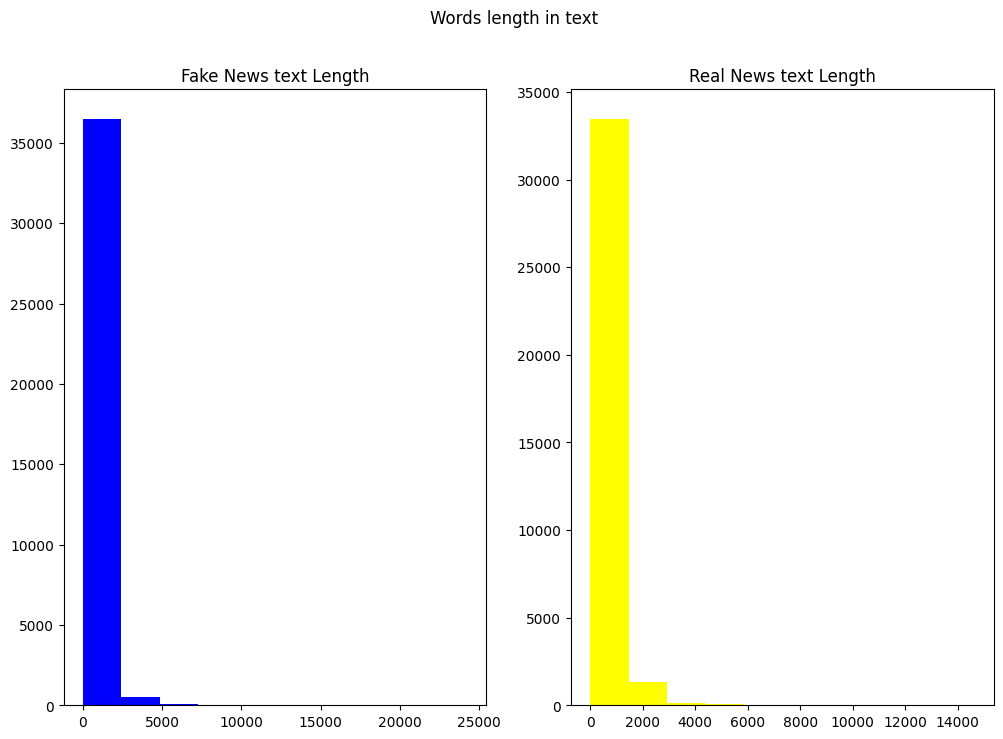

In [24]:
#Convert all non-string entries to empty strings
df['text'] = df['text'].astype(str).fillna('')

#Number of words in each text
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

# Plotting a histogram for Fake News text Length
text_len = df[df['label'] == "FAKE"]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len, color='blue')
ax1.set_title('Fake News text Length')

#Plotting a histogram for Real News text length
text_len = df[df['label'] == "REAL"]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len, color='yellow')
ax2.set_title('Real News text Length')

fig.suptitle('Words length in text')
plt.show()

label
FAKE    37106
REAL    35028
Name: text, dtype: int64


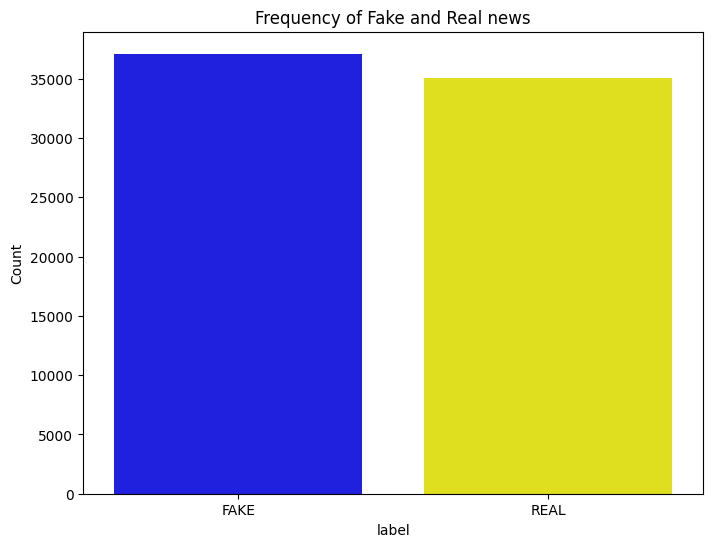

In [25]:
#Comparing the frequency of Fake and Real News
#Printing the frequency of Fake and Real News
print(df.groupby(['label'])['text'].count())

#Defining colour for the countplot
custom_palette = {'FAKE': 'blue', 'REAL': 'yellow'}

#Creating a countplot using seaborn and matplotlib with custom colors
plt.figure(figsize=(8,6))
sns.countplot(x='label', hue='label', data=df, palette=custom_palette, legend=False)
plt.title('Frequency of Fake and Real news')
plt.xlabel('label')
plt.ylabel('Count')
plt.show()

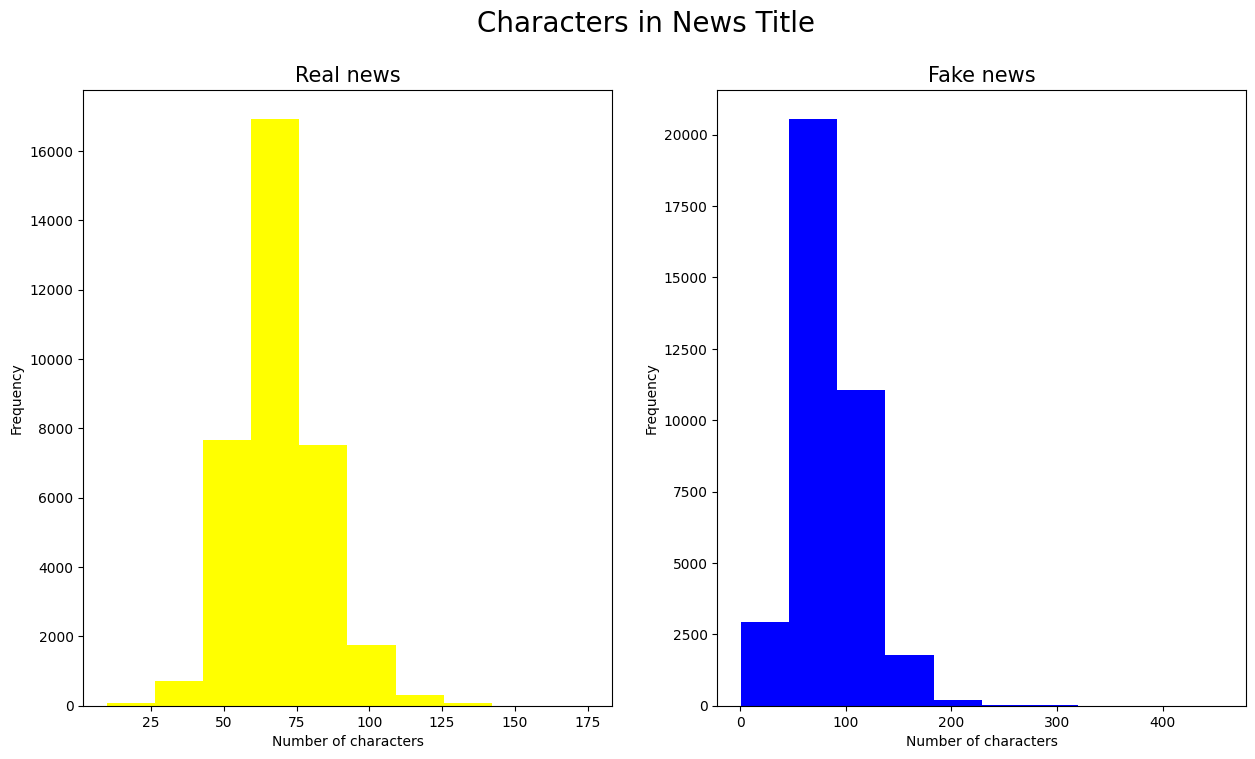

In [26]:
#Compare the total numbers of characters in the tile of the news
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle('Characters in News Title', fontsize=20)

#Histogram for Real news title length
news_len = df[df['label'] == 'REAL']['title'].str.len()
ax1.hist(news_len, color='yellow', linewidth=2)
ax1.set_title('Real news', fontsize=15)

#Histogram for Fake news title length
news_len = df[df['label'] == 'FAKE']['title'].str.len()
ax2.hist(news_len, color='blue', linewidth=2)
ax2.set_title('Fake news', fontsize=15)

#Adding styling and labels
ax1.set_xlabel('Number of characters')
ax1.set_ylabel('Frequency')
ax2.set_xlabel('Number of characters')
ax2.set_ylabel('Frequency')

plt.show()

## Bag of words

In [27]:
#Creating a bag of words that show the frequency of fake text
fake_text_freq = ' '.join([str(x) for x in df[df['label']=='FAKE']['new_text']])
a = nltk.FreqDist(fake_text_freq.split())
d = pd.DataFrame({'Word': list(a.keys()),
                  'Count': list(a.values())})
d.sample(10)            

,Word,Count
167110,chameleonlike,2
97257,la”,3
110354,mouselistener,2
125532,johnmclarke3,1
290139,futurephoto,1
274383,elkhazzaniel,1
28856,large”,11
60206,smails,1
94321,significó,1
248314,saadiq,8


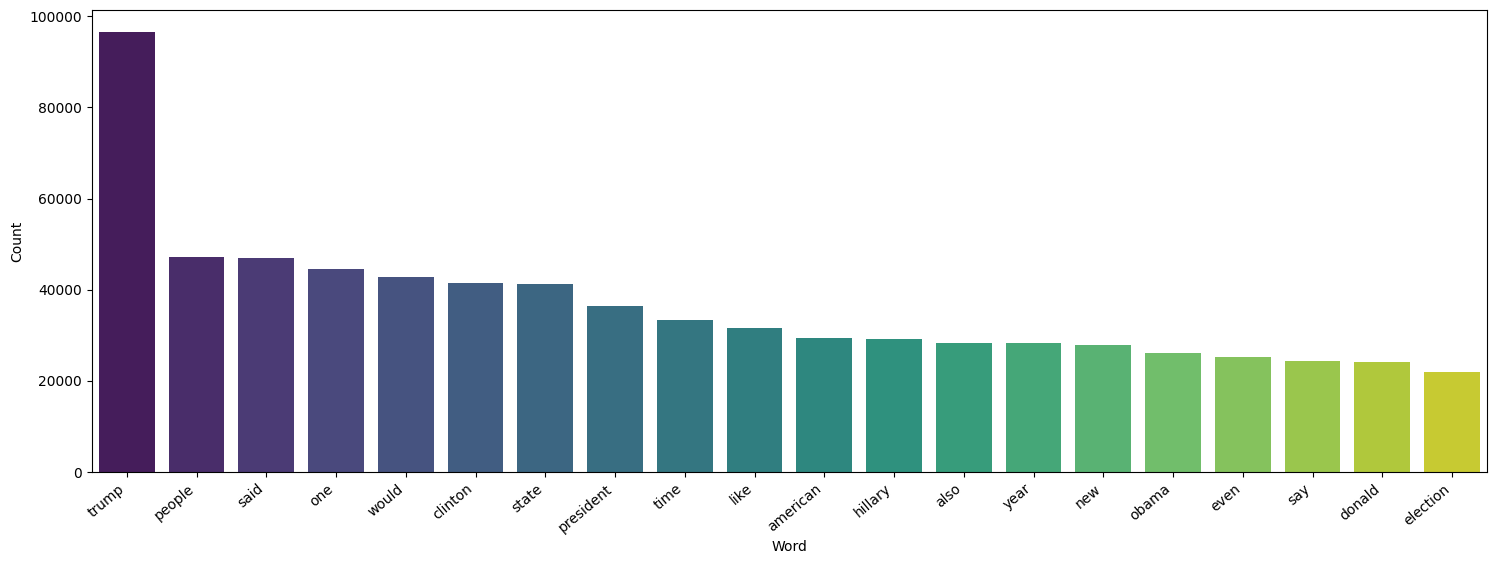

In [28]:
#Finding the top 20 most frequently used hashtags
d = d.nlargest(columns='Count', n = 20)
plt.figure(figsize=(18,6))
ax = sns.barplot(data=d, x='Word', y='Count', palette='viridis', hue='Word', legend=False)
ax.set_xticks(range(len(d['Word'])))
ax.set_xticklabels(d['Word'], rotation=40, ha='right')
ax.set(ylabel = 'Count')
plt.show()

In [29]:
#Creating a bag of words that show the frequency of real text
real_text_freq = ' '.join([str(x) for x in df[df['label']=='REAL']['new_text']])
a = nltk.FreqDist(real_text_freq.split())
d = pd.DataFrame({'Word': list(a.keys()),
                  'Count': list(a.values())})
d.sample(10)            

,Word,Count
42503,tiananmen,40
21611,”blasphemy”,2
184572,tittle,1
17524,19771980,1
158496,nahman,1
33865,treasurer’s,3
71403,7261t,3
144384,romanek,1
94003,“drama,2
8534,consultancy,138


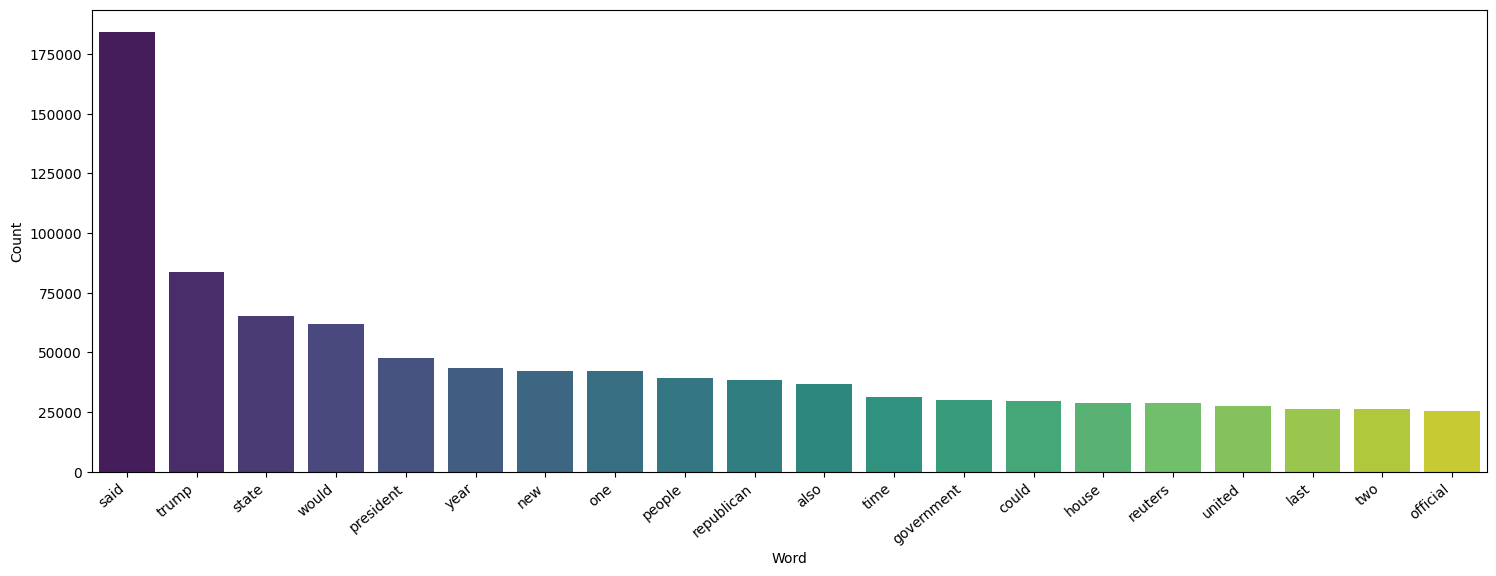

In [30]:
#Finding the top 20 most frequently used hashtags
d = d.nlargest(columns='Count', n = 20)
plt.figure(figsize=(18,6))
ax = sns.barplot(data=d, x='Word', y='Count', palette='viridis', hue='Word', legend=False)
ax.set_xticks(range(len(d['Word'])))
ax.set_xticklabels(d['Word'], rotation=40, ha='right')
ax.set(ylabel = 'Count')
plt.show()

In [31]:
df.head()

,Unnamed: 0,title,text,label,new_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,FAKE,comment expected barack obama member fyf911 fu...
1,1,NaN,Did they post their votes for Hillary already?,FAKE,post vote hillary already
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",FAKE,demonstrator gathered last night exercising co...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,REAL,dozen politically active pastor came private d...
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",FAKE,rs28 sarmat missile dubbed satan replace ss18 ...


In [32]:
df['label'] = df['label'].replace(['FAKE','REAL'], value=[1,0])

C:\Users\Samuel Tong\AppData\Local\Temp\ipykernel_24348\3611219152.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace(['FAKE','REAL'], value=[1,0])


In [33]:
df.head()

,Unnamed: 0,title,text,label,new_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,comment expected barack obama member fyf911 fu...
1,1,NaN,Did they post their votes for Hillary already?,1,post vote hillary already
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,demonstrator gathered last night exercising co...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,dozen politically active pastor came private d...
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,rs28 sarmat missile dubbed satan replace ss18 ...


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72134 non-null  object
 3   label       72134 non-null  int64 
 4   new_text    72134 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.8+ MB


## Finding the baseline model

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df['new_text'], df['label'], test_size=0.2, random_state = 10)

In [36]:
#Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer()

#Converting the text data into numerical features
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

#Printing the shape 
print(X_train.shape)
print(X_test.shape)

(57707, 318454)
(14427, 318454)


## Logistic Regression Model 

In [37]:
#Logistic Regression Model (Model 1)
#Training the model
log_reg_model = LogisticRegression(max_iter = 500)
log_reg_model.fit(X_train, y_train)

#Prediction
log_reg_pred = log_reg_model.predict(X_test)

#Finding the accuracy and cm
acc_lrm = accuracy_score(y_test, log_reg_pred)
cm_lrm = confusion_matrix(y_test, log_reg_pred)

#Printing the accuracy and confusion maxtrix for lrm
print('Accuracy Score: {}'.format(acc_lrm))
print('Confusion Matrix: \n {}'.format(cm_lrm))

Accuracy Score: 0.9507867193456713
Confusion Matrix: 
 [[6555  406]
 [ 304 7162]]


In [38]:
#Printing the classification report for lrm
print(classification_report(y_test, log_reg_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      6961
           1       0.95      0.96      0.95      7466

    accuracy                           0.95     14427
   macro avg       0.95      0.95      0.95     14427
weighted avg       0.95      0.95      0.95     14427



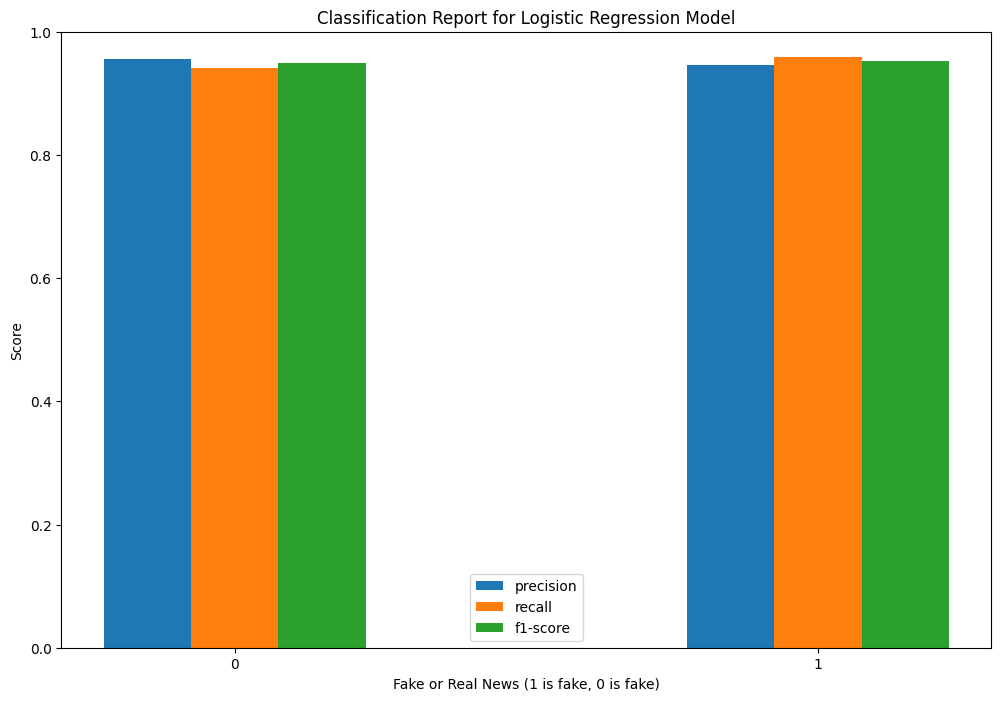

In [39]:
#Showing the classification report on a graph
report = classification_report(y_test, log_reg_pred, output_dict=True)
labels = list(report.keys())[:-3]
metrics = ['precision', 'recall', 'f1-score']

#Creating a bar plot
plt.figure(figsize=(12,8))
x = np.arange(len(labels))
width = 0.15

for i, metric in enumerate(metrics):
    scores = [report[label][metric] for label in labels]
    plt.bar(x + (i * width), scores, width, label = metric)

#Plotting the graph
plt.xticks(x + width, labels)
plt.title('Classification Report for Logistic Regression Model')
plt.xlabel('Fake or Real News (1 is fake, 0 is fake)')
plt.ylabel('Score')
plt.ylim(0.00, 1.00)
plt.legend()
plt.show()

## Decision Tree Classifier

In [40]:
#Decision Tree Classifier (Model 2)
#Training the model
decis_tree_model = DecisionTreeClassifier()
decis_tree_model.fit(X_train, y_train)

#Prediction
decis_tree_pred = decis_tree_model.predict(X_test)

#Finding the accuracy and cm
acc_dtc = accuracy_score(y_test, decis_tree_pred)
cm_dtc = confusion_matrix(y_test, decis_tree_pred)

#Printing the accuracy and confusion maxtrix for dtc
print('Accuracy Score: {}'.format(acc_dtc))
print('Confusion Matrix: \n {}'.format(cm_dtc))

Accuracy Score: 0.9312400360435295
Confusion Matrix: 
 [[6415  546]
 [ 446 7020]]


In [41]:
#Printing the classification report for dtc
print(classification_report(y_test, decis_tree_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      6961
           1       0.93      0.94      0.93      7466

    accuracy                           0.93     14427
   macro avg       0.93      0.93      0.93     14427
weighted avg       0.93      0.93      0.93     14427



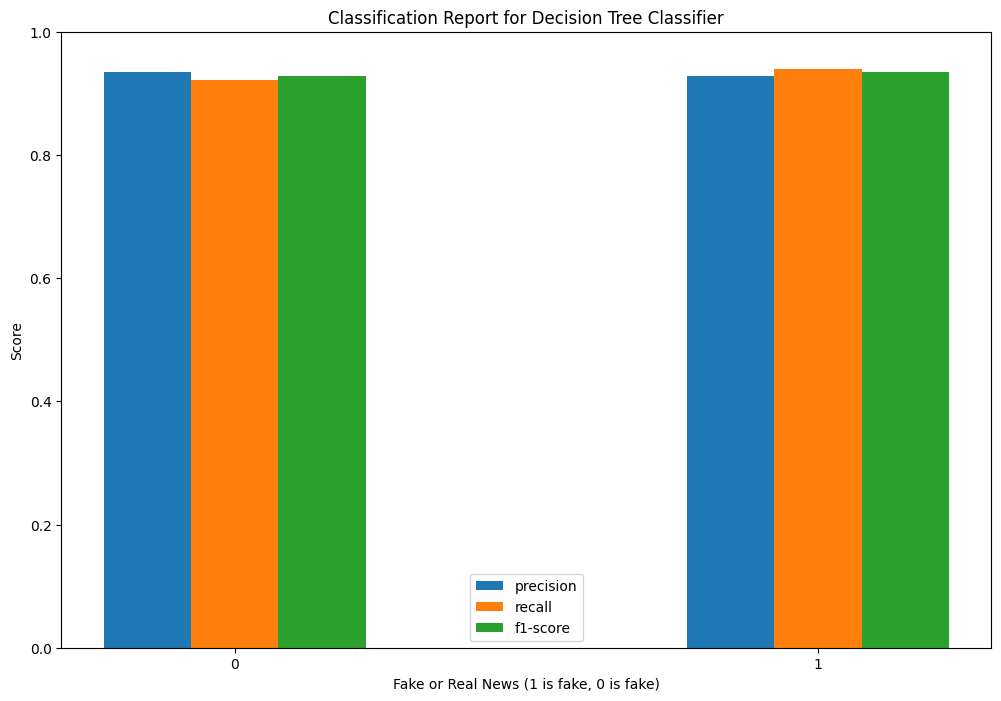

In [42]:
#Showing the classification report on a graph
report = classification_report(y_test, decis_tree_pred, output_dict=True)
labels = list(report.keys())[:-3]
metrics = ['precision', 'recall', 'f1-score']

#Creating a bar plot
plt.figure(figsize=(12,8))
x = np.arange(len(labels))
width = 0.15

for i, metric in enumerate(metrics):
    scores = [report[label][metric] for label in labels]
    plt.bar(x + (i * width), scores, width, label = metric)

#Plotting the graph
plt.xticks(x + width, labels)
plt.title('Classification Report for Decision Tree Classifier')
plt.xlabel('Fake or Real News (1 is fake, 0 is fake)')
plt.ylabel('Score')
plt.ylim(0.00, 1.00)
plt.legend()
plt.show()

## Random Forest Classifier

In [43]:
#Random Forest Classifier (Model 3)
#Training the model
rand_for_model = RandomForestClassifier()
rand_for_model.fit(X_train, y_train)

#Prediction
rand_for_pred = rand_for_model.predict(X_test)

#Finding the accuracy and cm
acc_rfc = accuracy_score(y_test, rand_for_pred)
cm_rfc = confusion_matrix(y_test, rand_for_pred)

#Printing the accuracy and confusion maxtrix for rfc
print('Accuracy Score: {}'.format(acc_rfc))
print('Confusion Matrix: \n {}'.format(cm_rfc))

Accuracy Score: 0.9393498301795244
Confusion Matrix: 
 [[6557  404]
 [ 471 6995]]


In [44]:
#Printing the classification report for rfc
print(classification_report(y_test, rand_for_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      6961
           1       0.95      0.94      0.94      7466

    accuracy                           0.94     14427
   macro avg       0.94      0.94      0.94     14427
weighted avg       0.94      0.94      0.94     14427



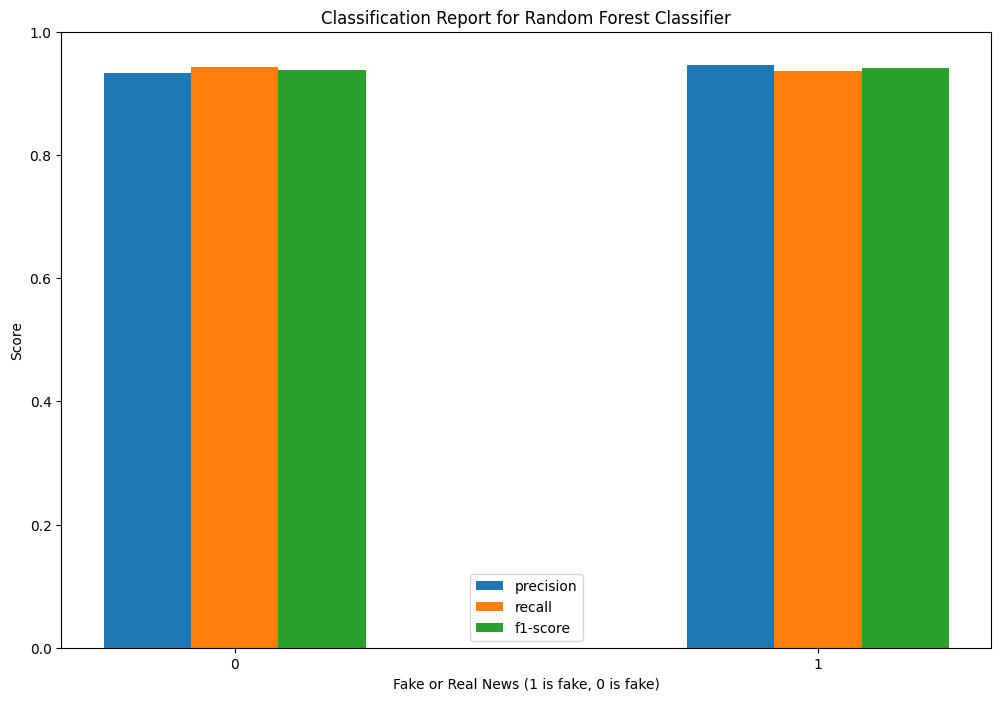

In [45]:
#Showing the classification report on a graph
report = classification_report(y_test, rand_for_pred, output_dict=True)
labels = list(report.keys())[:-3]
metrics = ['precision', 'recall', 'f1-score']

#Creating a bar plot
plt.figure(figsize=(12,8))
x = np.arange(len(labels))
width = 0.15

for i, metric in enumerate(metrics):
    scores = [report[label][metric] for label in labels]
    plt.bar(x + (i * width), scores, width, label = metric)

#Plotting the graph
plt.xticks(x + width, labels)
plt.title('Classification Report for Random Forest Classifier')
plt.xlabel('Fake or Real News (1 is fake, 0 is fake)')
plt.ylabel('Score')
plt.ylim(0.00, 1.00)
plt.legend()
plt.show()

## Accuracy Comparison between the models

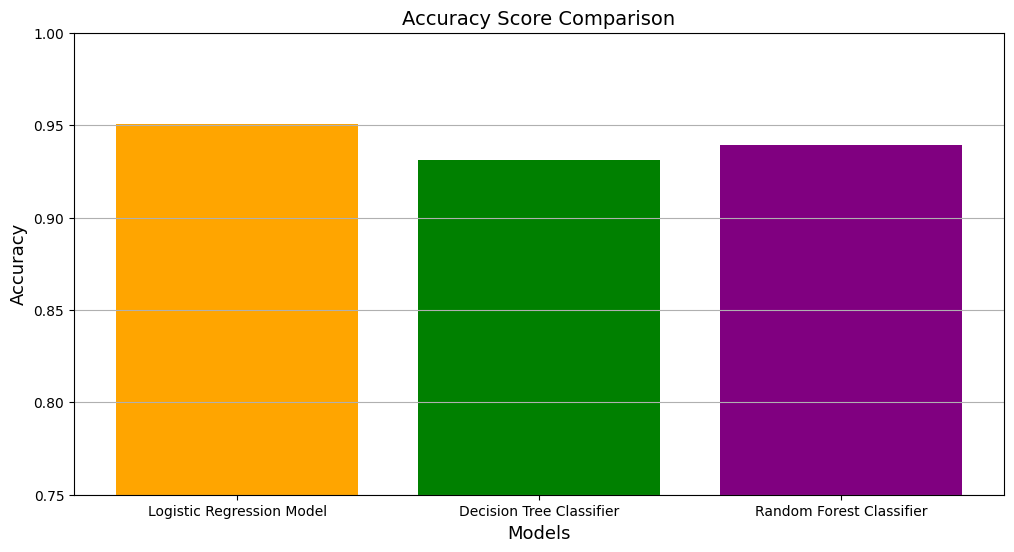

In [46]:
#Creating a list of models and their accuracy scores
models = ['Logistic Regression Model', 'Decision Tree Classifier', 'Random Forest Classifier']
acc_scores = [acc_lrm, acc_dtc, acc_rfc]
colours = ['orange', 'green', 'purple']

#Plotting the accuracy score of each model on a bar graph
plt.figure(figsize=(12, 6))
plt.bar(models, acc_scores, color=colours)
plt.title('Accuracy Score Comparison', fontsize=14)
plt.xlabel('Models', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.ylim(0.75, 1.00)
plt.grid(axis='y')
plt.show()

## Comparison between Model 1, Model 2 and Model 3
The Logistic Regression Model achieved an accuracy of 95.11% by correctly classifying 6552 instances as negative and 7169 instances as positive out of a total of 14427 samples. The Decision Tree Classifier achieved an accuracy of 93.33% by correctly classifying 6436 instances as negative and 7028 instances as positive out of 14427 samples. While the Random Forest Classifier achieved an accuracy of 93.89% by correctly classifying 6553 instances as negative and 6992 instances as positive out of 14427 samples. All models achieved relatively balanced precision, recall, and f1-score. The Logistic Regression Model has the highest accuracy score between the 3 different models and it could be consider a better choice for this particular scenario and be used as the baseline model for this project.

## Implementing the deep learning model using LSTM 

### Model Training and testing phase for the deep learning model

In [47]:
# Splitting the dataframe into training and testing sets for 80% and 20% respectively
df_train, df_test = train_test_split(df, test_size = 1 - 0.8, random_state=42)

# Printing the size of the training and testing sets
print("Train size:", len(df_train))
print("Test size:", len(df_test))

Train size: 57707
Test size: 14427


In [48]:
# Splitting the text context of each document in the 'df_train' dataframe into a list of words
documents = [_text.split() for _text in df_train.text]

### Using Tokenization

In [49]:
max_vocab = 10000
seq_len = 256

# Creating a tokenizer object and fit that object on the text data in 'df_train'
tokenizer = Tokenizer()
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(df_train.text)

In [50]:
# Converting the text in the training data to sequences of tokens and pad them into a fixed sequence length
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen= seq_len)

# Converting the text in the testing data to sequences of tokens and pad them into a fixed sequence length
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen = seq_len)

### Using label encoder

In [51]:
# Retriving the unique labels and converting them into a list
labels = df_train.label.unique().tolist()

labels

[0, 1]

In [52]:
# Creating a LabelEncoder object
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

# Transforming the values into numerical labels
y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

# Reshaping each label array to ensure compatibility with the model training
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Printing the shapes of the transformed label arrays
print("y_train:", y_train.shape)
print("y_test", y_test.shape)

y_train: (57707, 1)
y_test (14427, 1)


In [53]:
# Printing the other values
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print()
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (57707, 318454)
y_train: (57707, 1)

X_test: (14427, 318454)
y_test: (14427, 1)


In [54]:
y_train[:10]

array([[0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1]], dtype=int64)

### Training the deep learning model using LSTM

In [55]:
# Building a sequential neural network that contains embedding layer, dropout, LSTM, and dense layers
model = Sequential([
    Embedding(max_vocab, 128),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(16)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 

### Compiling the Model

In [56]:
# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Implementing a callback

In [57]:
# Defining a list of callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]

### Training the model

In [58]:
# Fitting the model to the training data
history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_split=0.1,
                    batch_size=30,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10


1732/1732 [==============================] - 161s 90ms/step - loss: 0.3948 - accuracy: 0.8624 - val_loss: 0.3148 - val_accuracy: 0.8799
Epoch 2/10
1732/1732 [==============================] - 153s 88ms/step - loss: 0.5057 - accuracy: 0.8740 - val_loss: 0.5204 - val_accuracy: 0.7747
Epoch 3/10
1732/1732 [==============================] - 153s 88ms/step - loss: 0.2646 - accuracy: 0.9189 - val_loss: 0.2355 - val_accuracy: 0.9361
Epoch 4/10
1732/1732 [==============================] - 152s 88ms/step - loss: 0.2026 - accuracy: 0.9450 - val_loss: 0.2660 - val_accuracy: 0.9199
Epoch 5/10
1732/1732 [==============================] - 153s 88ms/step - loss: 0.1670 - accuracy: 0.9583 - val_loss: 0.2116 - val_accuracy: 0.9491
Epoch 6/10
1732/1732 [==============================] - 153s 88ms/step - loss: 0.1062 - accuracy: 0.9768 - val_loss: 0.2541 - val_accuracy: 0.9593
Epoch 7/10
1732/1732 [==============================] - 151s 87ms/step - loss: 0.0844 - accuracy: 0.9849 - val_loss:

### Analysing and testing

In [59]:
# Evaluting the model on the test data
score = model.evaluate(x_test, y_test)

# Printing the values
print()
print("Accuracy:", score[1])
print("Loss:", score[0])

451/451 [==============================] - 12s 26ms/step - loss: 0.2156 - accuracy: 0.9520

Accuracy: 0.9520343542098999
Loss: 0.21558262407779694


<function matplotlib.pyplot.show(close=None, block=None)>

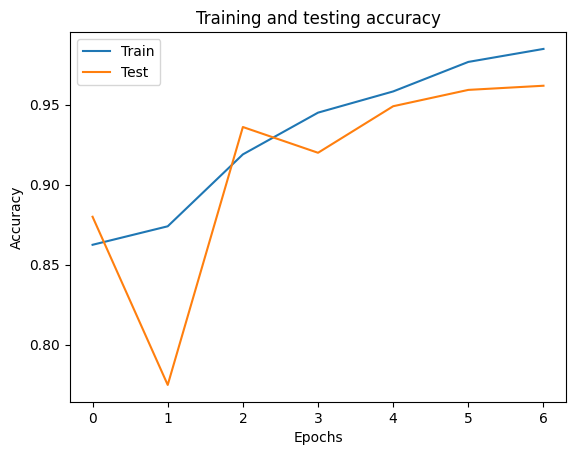

In [60]:
# Plotting a graph to visualise the training and testing accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Training and testing accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show

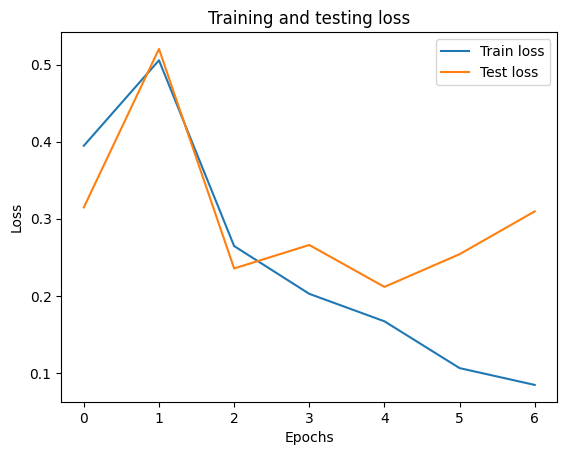

In [61]:
# Plotting a graph to visualise the training and testing loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.title('Training and testing loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [62]:
# Predicting probabilities for each class
pred_prob = model.predict(x_test)

# Convert probabilities to class predictions using a threshold
threshold = 0.5
pred = (pred_prob > threshold).astype(int)

451/451 [==============================] - 13s 26ms/step


In [63]:
pred_model = model.predict(x_test)

451/451 [==============================] - 12s 26ms/step


### Confusion Matrix

In [64]:
# Printing the values
print("Length of y_test:", len(y_test))
print("Length of pred:", len(pred))

Length of y_test: 14427
Length of pred: 14427


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

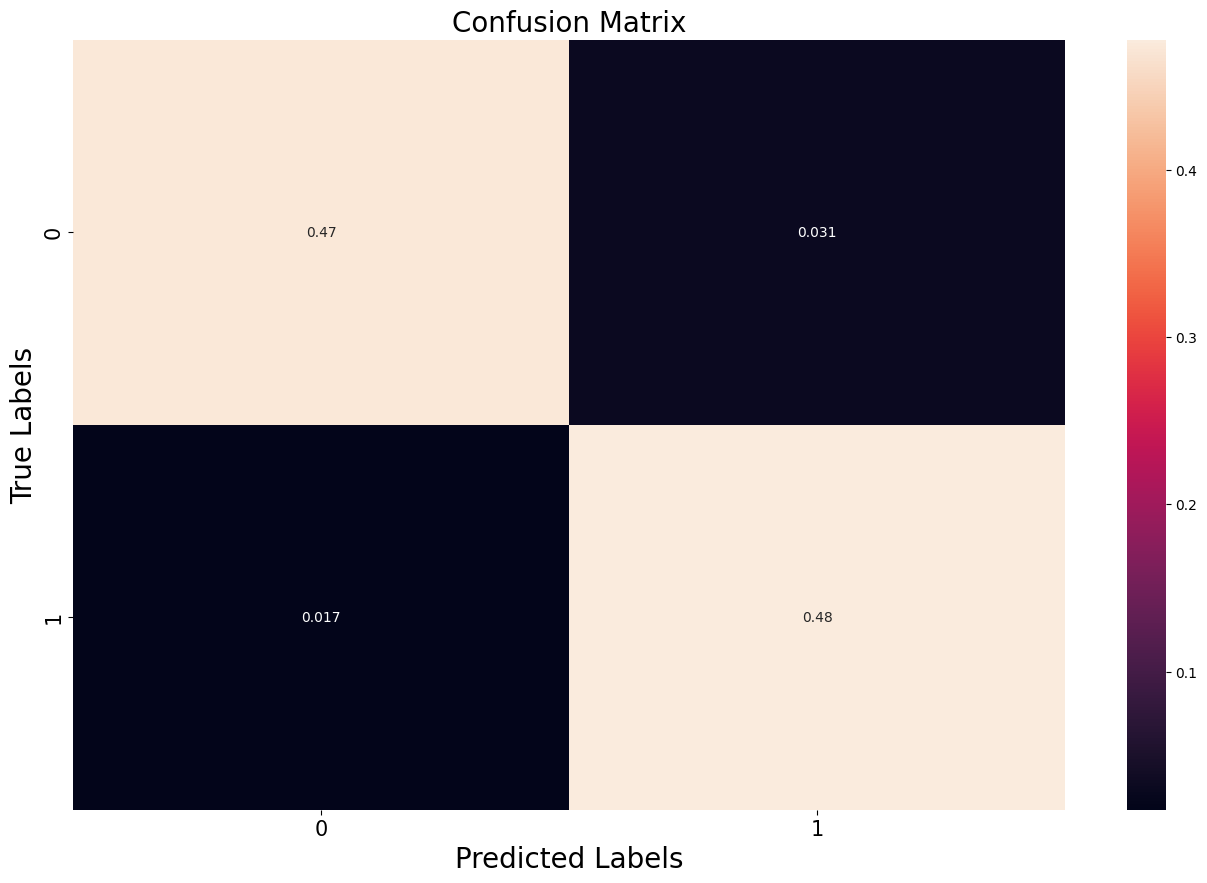

In [65]:
# Plotting the confusion matrix
bilstm_cm = confusion_matrix(pred, y_test, normalize='all')
plt.figure(figsize=(16,10))
ax = plt.subplot()
sns.heatmap(bilstm_cm, annot=True, ax = ax)

# Setting labels, titles and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

In [66]:
# Printing the classification report 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7089
           1       0.97      0.94      0.95      7338

    accuracy                           0.95     14427
   macro avg       0.95      0.95      0.95     14427
weighted avg       0.95      0.95      0.95     14427



In [67]:
# Calculating and printing the accuracy score
accuracy = accuracy_score(y_test, pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.95


### Save the models

In [68]:
# Defining the filenames for saving the models
bilstm_MODEL = 'model.keras'
TOKENIZER_MODEL = 'tokenizer.pkl'
ENCODER_MODEL = 'encoder.pkl'

# Save the trained models
model.save(bilstm_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

### Manual testing

In [69]:
# Placeholder functions for preprocessing steps
def do_fake_news_prediction(text):
    result_text_rem_punc = remove_punctuation(text)
    result_text_tokenize = tokenize(result_text_rem_punc)
    result_text_rem_small_words = remove_sml_words(result_text_tokenize)
    result_text_rem_stopwords = remove_stopword(result_text_rem_small_words)
    result_text_lemmatizer = lemmatizer(result_text_rem_stopwords)
    result_text_return_sentences = return_sentences(result_text_lemmatizer)
    result_text = result_text_return_sentences

    # Tokenize text using the loaded tokenizer
    tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))
    tokenized_text = tokenizer.texts_to_sequences([result_text])

    # Pad the tokenized text to a fixed length of 350 (adjust as needed)
    max_sequence_length = 350
    padded_text = pad_sequences(tokenized_text, maxlen= max_sequence_length)

    # Load bilstm model
    model = load_model('model.keras')

    # Predict using bilstm model
    predictions = model.predict(padded_text)

    return predictions

# Example usage to test 
fake_news_result = do_fake_news_prediction('Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year!  Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you  Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress.  Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me?  Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish??  Marlene (@marlene399) December 31, 2017You can t just say happy new year?  Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love!  Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his  enemies  and  haters  for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA  Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President?  Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down.  Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters?  Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old  Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.')
real_news_result = do_fake_news_prediction('WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trumpâ€™s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administrationâ€™s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. â€œThe Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DODâ€™s study and will continue to defend the presidentâ€™s lawful authority in District Court in the meantime,â€ the official said, speaking on condition of anonymity. In September, the Pentagon said it had created a panel of senior officials to study how to implement a directive by Trump to prohibit transgender individuals from serving. The Defense Department has until Feb. 21 to submit a plan to Trump. Lawyers representing currently-serving transgender service members and aspiring recruits said they had expected the administration to appeal the rulings to the conservative-majority Supreme Court, but were hoping that would not happen. Pentagon spokeswoman Heather Babb said in a statement: â€œAs mandated by court order, the Department of Defense is prepared to begin accessing transgender applicants for military service Jan. 1. All applicants must meet all accession standards.â€ Jennifer Levi, a lawyer with gay, lesbian and transgender advocacy group GLAD, called the decision not to appeal â€œgreat news.â€ â€œIâ€™m hoping it means the government has come to see that there is no way to justify a ban and that itâ€™s not good for the military or our country,â€ Levi said. Both GLAD and the American Civil Liberties Union represent plaintiffs in the lawsuits filed against the administration. In a move that appealed to his hard-line conservative supporters, Trump announced in July that he would prohibit transgender people from serving in the military, reversing Democratic President Barack Obamaâ€™s policy of accepting them. Trump said on Twitter at the time that the military â€œcannot be burdened with the tremendous medical costs and disruption that transgender in the military would entail.â€ Four federal judges - in Baltimore, Washington, D.C., Seattle and Riverside, California - have issued rulings blocking Trumpâ€™s ban while legal challenges to the Republican presidentâ€™s policy proceed. The judges said the ban would likely violate the right under the U.S. Constitution to equal protection under the law. The Pentagon on Dec. 8 issued guidelines to recruitment personnel in order to enlist transgender applicants by Jan. 1. The memo outlined medical requirements and specified how the applicantsâ€™ sex would be identified and even which undergarments they would wear. The Trump administration previously said in legal papers that the armed forces were not prepared to train thousands of personnel on the medical standards needed to process transgender applicants and might have to accept â€œsome individuals who are not medically fit for service.â€ The Obama administration had set a deadline of July 1, 2017, to begin accepting transgender recruits. But Trumpâ€™s defense secretary, James Mattis, postponed that date to Jan. 1, 2018, which the presidentâ€™s ban then put off indefinitely. Trump has taken other steps aimed at rolling back transgender rights. In October, his administration said a federal law banning gender-based workplace discrimination does not protect transgender employees, reversing another Obama-era position. In February, Trump rescinded guidance issued by the Obama administration saying that public schools should allow transgender students to use the restroom that corresponds to their gender identity.')
print(real_news_result)

1/1 [==============================] - 1s 930ms/step
[[0.22050601]]


In [70]:
# Define the manual_testing function
def manual_testing(news, model):
    # Applying preprocessing steps 
    result_text = do_fake_news_prediction(news)

    print(result_text)

    # Displaying the predictions
    prediction_label = output_label(result_text)
    print("Model Prediction: {}".format(prediction_label))

# Placeholder function for output_label
def output_label(prediction):
    # If prediction >= threshold, return 'Fake News', else return 'Real News'
    if prediction >= 0.5:
        return 'Fake News'
    else:
        return 'Real News'

In [71]:
# Calling the manual_testing function
news = input("Enter the news text: ")
manual_testing(news, model)

Enter the news text: It's primary day in New York and front-runners Hillary Clinton and Donald Trump are leading in the polls.  Trump is now vowing to win enough delegates to clinch the Republican nomination and prevent a contested convention. But Sens.Ted Cruz, R-Texas, Bernie Sanders, D-Vt., and Ohio Gov. John Kasich and aren't giving up just yet.  A big win in New York could tip the scales for both the Republican and Democratic front-runners in this year's race for the White House. Clinton and Trump have each suffered losses in recent contests, shifting the momentum to their rivals.  "We have won eight out of the last nine caucuses and primaries! Cheer!" Sanders recently told supporters.  While wins in New York for Trump and Clinton are expected, the margins of those victories are also important.  Trump needs to capture more than 50 percent of the vote statewide if he wants to be positioned to win all of the state's 95 GOP delegates. That would put him one step closer to avoiding a 

## Creating the webpage

In [72]:
%%writefile index.html

<!-- This HTML/CSS code defines a web interface for a Fake News Detection App.
     Users can input text or upload a file to predict whether it's fake or real news, 
     and view the prediction result on the web application page. -->

<!DOCTYPE html> 
<html lang="en"> 
  <head> 
    <meta charset="UTF-8" /> 
    <meta name="viewport" content="width=device-width, initial-scale=1.0" /> 
    <link rel="preconnect" href="https://fonts.googleapis.com" /> 
    <link rel="preconnect" href="https://fonts.gstatic.com" crossorigin /> 
    <link 
      href="https://fonts.googleapis.com/css2?family=Roboto&display=swap" 
      rel="stylesheet" 
    /> 
    <title>Fake News Detection Application</title> 
    <style> 
      html { 
        box-sizing: border-box; 
        font-size: 100%; 
      } 
 
      *, 
      *::before, 
      *::after { 
        margin: 0; 
        padding: 0; 
        box-sizing: inherit; 
      } 
 
      body { 
        margin: 0; 
        padding: 0; 
        font-family: "Roboto", sans-serif; 
        min-height: 100vh; 
        background: radial-gradient(circle, rgb(238, 174, 202) 0%, rgb(148, 187, 233) 100%); 
      } 
 
      section { 
        width: 800px; 
        margin: 8rem auto; 
      } 
 
      section .container { 
        background: radial-gradient(circle, rgb(128, 198, 155) 0%, rgb(148, 187, 233) 100%); 
        color: rgb(17, 14, 14);
        border-radius: 1rem; 
        display: flex; 
        justify-content: center; 
        align-items: center; 
        flex-direction: column; 
        padding: 1rem; 
        gap: 1rem; 
#         box-shadow: -2px 10px 5px 0px rgba(0, 0, 0, 0.75); 
#         -webkit-box-shadow: -2px 10px 5px 0px rgba(0, 0, 0, 0.75); 
#         -moz-box-shadow: -2px 10px 5px 0px rgba(0, 0, 0, 0.75); 
        box-shadow: 0px 0px 5px 0px rgba(0, 0, 0, 0.75);
      } 
 
      section .container .inputfile { 
        width: 0.1px; 
        height: 0.1px; 
        opacity: 0; 
        overflow: hidden; 
        position: absolute; 
        z-index: -1; 
      } 
 
      section .container .inputfile + label { 
        font-size: 1.25em; 
        font-weight: 700; 
        color: white; 
        padding: 1rem 2rem; 
        border-radius: 2rem; 
        background-color: black; 
        display: inline-block; 
        transition: all 200ms ease-in-out; 
      } 
 
      section .container .inputfile:focus + label, 
      section .container .inputfile + label:hover { 
        background-color: red; 
      } 
 
      section .container .inputfile + label { 
        cursor: pointer; 
      } 
 
      section .container button { 
        display: inline-block; 
        font-size: 1em; 
        font-weight: 700; 
        color: black; 
        padding: 1rem 2rem; 
        border-radius: 2rem; 
        cursor: pointer; 
        transition: all 200ms ease-in-out; 
      } 
 
      section .container button:hover { 
        background-color: yellow; 
      } 
 
      section .container textarea { 
        margin: 1.5rem 0; 
        border: none; 
        text-align: center; 
        outline: none; 
      }   
    
      section .container prediction-result {
        font-size: 100px;
        margin-top: 20px;
      }
      
    </style> 
  </head> 
  
    <title>Fake News Detection App</title>
    <script>
    
        function limitWords(textarea, maxWords) {
            const text = textarea.value;
            const words = text.split(/\s+/);
            if (words.length > maxWords) {
                textarea.value = words.slice(0, maxWords).join(" ");
            }
            document.getElementById("word-count").textContent = `Word Count: ${words.length} / ${maxWords}`;
        }
        
        function showPrediction() {
            const predictionLabel = document.getElementById('prediction-result');
            predictionLabel.style.display = 'block'; 
        }
        
        function clearPrediction() {
            const predictTextarea = document.getElementById("predict");
            const predictionResultLabel = document.getElementById("prediction-result");

            // Clear the input textarea
            predictTextarea.value = "";

            // Hide the prediction result label
            predictionResultLabel.style.display = "none";

            // Reset the word count display
            document.getElementById("word-count").textContent = "Word Count: 0 / 1000";
        }

        document.addEventListener("DOMContentLoaded", function() {

            const predictTextarea = document.getElementById("predict");
            const fileInput = document.getElementById("file");
            const fileInputLabel = document.getElementById("file-label");
            const predictButton = document.getElementById("predictbtn");
            const uploadButton = document.getElementById("uploadbtn");
            const predictionResultLabel = document.getElementById("prediction-result");

            fileInput.addEventListener("change", () => {
                const selectedFile = event.target.files[0];
                if (selectedFile) {
                    //const fileContent = await readFileContent(selectedFile);
                    // predictTextarea.value = fileContent;
                    fileInputLabel.textContent = `Selected File: ${selectedFile.name}`;
                }
            });

            uploadButton.addEventListener("click", async() => {
                // Load content of selected file into predict textarea
                const selectedFile = fileInput.files[0];
                if (selectedFile) {
                    try {
                        const fileContent = await readFileContent(selectedFile);
                        predictTextarea.value = fileContent;
                    } catch (error) {
                        console.error("Error reading file:", error);
                    }
                }
            });

            predictButton.addEventListener("click", async () => {
                const predictionText = predictTextarea.value;
                const response = await fetch("http://localhost:5001/predict", {
                    method: "POST",
                    headers: {
                        "Content-Type": "application/json"
                    },
                    body: JSON.stringify({ text: predictionText })
                });

                if (response.ok) {
                    const predictionResult = await response.json();
                    // Update the predict textarea with the prediction result
                    predictionResultLabel.textContent = predictionResult.prediction;

                    // Change label color based on prediction
                    if (predictionResult.prediction === "Fake News") {
                        predictionResultLabel.style.color = "red";
                    } else if (predictionResult.prediction === "Real News") {
                        predictionResultLabel.style.color = "green";
                    } else {
                        // Default color if neither "Fake News" nor "Real News"
                        predictionResultLabel.style.color = "black";
                    }


                } else {
                    console.error("Failed to fetch prediction");
                }
            });


            async function readFileContent(file) {
                return new Promise((resolve, reject) => {
                    const reader = new FileReader();
                    reader.onload = (event) => {
                        resolve(event.target.result);
                    };
                    reader.onerror = (error) => {
                        reject(error);
                    };
                    reader.readAsText(file);
                });
            }


        });
    </script>
  
  <body> 
    <section> 
      <div class="container"> 
        <h1 class="__header">Fake News Detection App</h1> 
        <p class="__para"></p> 
 
        <input type="file" name="file" id="file" class="inputfile" accept="text/plain" /> 
         <label for="file" id="file-label">Choose a file</label>

        <div class="button-wrap"> 
          <button id='uploadbtn' name='uploadbtn'>upload</button> 
        </div> 
 
        <textarea 
          name="predict" 
          id="predict" 
          cols="80" 
          rows="10" 
          placeholder="input-text" 
          oninput="limitWords(this, 1000)" 
        ></textarea>
        <p id="word-count">Word Count: 0 / 1000</p>
            
        <div class="button-wrap">
          <button id='predictbtn' name='predictbtn' onclick="showPrediction()">Predict</button>
          <button id='clearbtn' name='clearbtn' onclick="clearPrediction()">Clear</button>
        </div>

        <label id='prediction-result' name='prediction-result' style='font-size: 30px; display: none;'>Prediction in progress...</label>

            
      </div> 
    </section> 
  </body> 
</html>

Overwriting index.html


### Displaying the HTML webpage

In [73]:
from IPython.display import HTML

html_content = '<iframe src="index.html" width="900" height="800"></iframe>'

display(HTML(html_content))

C:\Users\Samuel Tong\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Web Application Usage
Run the web application on http://localhost:5001

To submit the news text within the web application, users are able to upload a text file (*.txt) or entering a text into the text box.

In [ ]:
from flask import Flask, render_template, request
from flask_cors import CORS


# Create a Flask web application instance
app = Flask(__name__)

# Enable CORS for all routes
CORS(app)

# Define routes and their corresponding functions
@app.route('/')
def home(): 
    import os
    # return os.getcwd()
    return render_template('index.html')

@app.route("/html")
def html():
    return render_template('index.html')

@app.route('/hello/<name>')
def hello(name):
    return f"Hello, {name}!"

@app.route('/predict', methods=['POST'])
def predict():
    prediction_text = request.json.get('text', '')
    print(prediction_text)
    prediction = do_fake_news_prediction(prediction_text)
 
    # Assuming the model outputs a probability (0-1)
    if prediction >= 0.5:
        result = 'Fake News'
        print(f"{prediction}")
        print("Fake News")
    else:
        result = 'Real News'
        print(f"{prediction}")
        print("Real News")
        
    return {'prediction': result}

# Run the Flask app
if __name__ == '__main__':
    app.run(host='localhost', port=5001)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://localhost:5001
Press CTRL+C to quit
[2024-08-30 17:02:06,825] ERROR in app: Exception on / [GET]
Traceback (most recent call last):
  File "C:\Users\Samuel Tong\AppData\Local\Programs\Python\Python310\lib\site-packages\flask\app.py", line 1473, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\Samuel Tong\AppData\Local\Programs\Python\Python310\lib\site-packages\flask\app.py", line 882, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\Samuel Tong\AppData\Local\Programs\Python\Python310\lib\site-packages\flask_cors\extension.py", line 178, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "C:\Users\Samuel Tong\AppData\Local\Programs\Python\Python310\lib\site-packages\flask\app.py", line 880, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\Samuel Tong\AppData\Local\Programs\Python\Python310\lib\site-packages\flask\app.py", line 865, in dispa

NEW YORK/WASHINGTON (Reuters) - The new U.S. tax code targets high-tax states and may be unconstitutional, New York Governor Andrew Cuomo said on Thursday, saying that the bill may violate New York residentsâ€™ rights to due process and equal protection.  The sweeping Republican tax bill signed into law by U.S. President Donald Trump on Friday introduces a cap, of $10,000,  on deductions of state and local income and property taxes, known as SALT. The tax overhaul was the partyâ€™s first major legislative victory since Trump took office in January.  The SALT provision will hit many taxpayers in states with high incomes, high property values and high taxes, like New York, New Jersey and California. Those states are generally Democratic leaning.  â€œIâ€™m not even sure what they did is legally constitutional and thatâ€™s something weâ€™re looking at now,â€ Cuomo said in an interview with CNN. In an interview with CNBC, Cuomo suggested why the bill may be unconstitutional.  â€œPolitics d

127.0.0.1 - - [30/Aug/2024 17:08:42] "POST /predict HTTP/1.1" 200 -


[[-0.06334424]]
Real News
Republicans are working overtime trying to sell their scam of a tax bill to the public as something that directly targets middle-class and working-class families with financial relief. Nothing could be further from the truth, and they re getting hammered on that repeatedly. Speaking on CNBC, Paul Ryan was going full throttle, trying to convince us that the paltry savings we re getting is actually wait for it big money.But he didn t just go with the usual talking points. With a smug look that only someone who grew up in a wealthy family can muster when talking about that which he does not know, Ryan claimed that the $2,059 more per year that families living paycheck-to-paycheck will see is extremely significant. Then he decided he had to amend that to say such savings might be nothing to a family earning $600,000 per year (true), or for people living in New York or California (false).Those are the same two states that Trump s loyal subjects insist on stripping 

127.0.0.1 - - [30/Aug/2024 17:09:24] "POST /predict HTTP/1.1" 200 -


[[1.6945752]]
Fake News
Republicans are working overtime trying to sell their scam of a tax bill to the public as something that directly targets middle-class and working-class families with financial relief. Nothing could be further from the truth, and they re getting hammered on that repeatedly. Speaking on CNBC, Paul Ryan was going full throttle, trying to convince us that the paltry savings we re getting is actually wait for it big money.But he didn t just go with the usual talking points. With a smug look that only someone who grew up in a wealthy family can muster when talking about that which he does not know, Ryan claimed that the $2,059 more per year that families living paycheck-to-paycheck will see is extremely significant. Then he decided he had to amend that to say such savings might be nothing to a family earning $600,000 per year (true), or for people living in New York or California (false).Those are the same two states that Trump s loyal subjects insist on stripping fr

127.0.0.1 - - [30/Aug/2024 17:09:33] "POST /predict HTTP/1.1" 200 -


[[1.6945752]]
Fake News
Syrian War Report â€“ October 31, 2016: Al-Nusra-led Forces Failed to Break Aleppo Siege â€¹ â€º South Front Analysis & Intelligence is a public analytical project maintained by an independent team of experts from the four corners of the Earth focusing on international relations issues and crises. They focus on analysis and intelligence of the ongoing crises and the biggest stories from around the world: Ukraine, the war in Middle East, Central Asia issues, protest movements in the Balkans, migration crises, and others. In addition, they provide military operations analysis, the military posture of major world powers, and other important data influencing the growth of tensions between countries and nations. We try to dig out the truth on issues which are barely covered by governments and mainstream media. Syrian War Report â€“ November 1, 2016: Syrian Military Deploys Advanced T-90 Battle Tanks to Aleppo By South Front on November 1, 2016 â€¦from SouthFront 
The

127.0.0.1 - - [30/Aug/2024 17:10:20] "POST /predict HTTP/1.1" 200 -


[[3.3887942]]
Fake News
Presidential hopefuls in both parties agree on at least one thing: Economic mobility, and the feeling of many Americans that they are being shut out from the nationâ€™s prosperity, will be a defining theme of the 2016 campaign. Former Florida governor Jeb Bush last week became the latest Republican to signal a readiness to engage Democrats on what historically has been their turf, putting issues of middle-class wage stagnation, poverty and shared prosperity at the forefront of their political messages. Bushâ€™s framing of the economic and social challenges facing the country nearly mirrors that of likely Democratic candidate Hillary Rodham Clinton, as well as other possible contenders on the left. Sen. Marco Rubio (R-Fla.) has written a book on the subject, â€œAmerican Dreams: Restoring Economic Opportunity for Everyone,â€ to be published this week, while Sen. Rand Paul (R-Ky.) has proposed policies for distressed communities that he sees as â€œthe ticket to th

127.0.0.1 - - [30/Aug/2024 17:11:04] "POST /predict HTTP/1.1" 200 -


[[0.05358186]]
Real News


127.0.0.1 - - [30/Aug/2024 17:12:51] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Aug/2024 17:18:31] "GET / HTTP/1.1" 200 -


SINGAPORE – A woman was charged on Aug 30 with attempting to commit robbery after she allegedly armed herself with a knife and approached a customer at an eatery in a mall in Novena.

Lam Hoe Lian, 50, is accused of committing the offence at Han’s Cafe in Velocity @ Novena Square shopping mall shortly after 9.30am on Aug 29.

In an earlier statement, the police said officers had arrested a woman after she allegedly took a knife from a table at the eatery and tried to rob a customer.

She left empty-handed when the restaurant’s staff intervened.

The police managed to identify the woman through inquiries and with the help of devices such as police cameras. Officers arrested her within nine hours and seized the knife.

On Aug 30, the court ordered Lam to be remanded at the Institute of Mental Health for an examination. Her case has been adjourned to Sept 13.

Those convicted of attempting to commit robbery can be jailed for between two and seven years and receive at least six strokes of 

127.0.0.1 - - [30/Aug/2024 17:18:59] "POST /predict HTTP/1.1" 200 -


[[0.2749805]]
Real News
A group of rogue scientists claimed to have discovered a cure for all known diseases using advanced alien technology found in a hidden government lab. According to the fake report, this miraculous cure is said to be able to reverse conditions like cancer, diabetes, Alzheimer's, and even aging within hours. The "news" suggests that the government is suppressing this information to keep pharmaceutical companies in business. The article includes fabricated quotes from "anonymous sources" and poorly doctored images of alien artifacts.
1/1 [==============================] - 1s 899ms/step


127.0.0.1 - - [30/Aug/2024 17:19:39] "POST /predict HTTP/1.1" 200 -


[[2.1207304]]
Fake News
Homeless Woman Protects Trumpâ€™s Walk of Fame Star From Violent Leftists "I'm gonna stay here and watch this, and make sure nobody touches it." Chris Menahan | Information Liberation - October 28, 2016 Comments 
Powerful video shows a homeless woman protecting Donald Trumpâ€™s Walk of Fame Star after it was smashed by a criminal leftist. 
As The Gateway Pundit reports , the woman was seen holding up a sign reading: â€œ20 Million Illegals and Americans Sleep on the Streets in Tents. Vote Trump.â€ 
It was repaired on the same day. 
The day after, this homeless Trump supporter went to protect it. 
â€œIâ€™m gonna stay here and watch this, and make sure nobody touches it,â€ she was heard saying. Homeless Trump supporter guards @realDonaldTrump 's star on Hollywood Blvd. against all SJWs #BasedSentinel #MAGA3X https://t.co/BjGcFO0du5 ? pic.twitter.com/nrMqnbW5UK 
â€” PeterDuke MAGA3XðŸ‡ºðŸ‡¸ (@peterdukephoto) October 27, 2016 
Video shared on Periscope shows hordes

127.0.0.1 - - [30/Aug/2024 17:20:29] "POST /predict HTTP/1.1" 200 -


[[2.7646673]]
Fake News


127.0.0.1 - - [30/Aug/2024 17:21:07] "GET / HTTP/1.1" 200 -


For a long time in American politics, we've been trapped in a cycle of ever-escalating political polarization. As measured by voting patterns in the US Congress, the two parties have pulled apart to distances we've never seen before. As measured by consistent partisan positioning among voters, the split in the electorate has reached a historic level of divisiveness. But this is about to end. We've now hit peak polarization. The forces that have fueled the widening gap between the two political parties are now fueling fights within the two political parties, fights that will lead to new coalitions in American politics, eventually realigning the two parties. A new era of American politics is about to emerge. The tautological reason polarization has increased in American politics is that over the past four decades, conflict in American politics has increasingly operated along a single dimension: Republican versus Democrat. A large number of issues that were once nonpartisan or non-ideolog

127.0.0.1 - - [30/Aug/2024 17:21:23] "POST /predict HTTP/1.1" 200 -


[[-0.0332783]]
Real News
Breaking News Pieczenik â€œRogue FBI Agents and Wikileaks are Spearheading a Movement to Stop the Clintons from Stealing the White Houseâ€ Pieczenik â€œRogue FBI Agents and Wikileaks are Spearheading a Movement to Stop the Clintons from Stealing the White Houseâ€ Breaking News By Amy Moreno November 2, 2016 
The world is teaming up to stop crooked Hillary from taking the White House. 
From Wikileaks to rogue FBI agents, everyone is doing their part to stop the sinister Clinton Machine. 
Itâ€™s a joint effort from patriots hailing from every corner of the world. 
Watch the video: Breaking:Twitter Friendly Version A soft coup has been launched by FBI to overthrow the Clintonâ€™s hostile takeover of the White House. pic.twitter.com/MrPUlSO1OE 
â€” OakTown â˜¢MAGA O.Gâ˜¢ (@hrtablaze) November 2, 2016 This is a movement â€“ we are the political OUTSIDERS fighting against the FAILED GLOBAL ESTABLISHMENT! Join the resistance and help us fight to put America First! A

127.0.0.1 - - [30/Aug/2024 17:21:59] "POST /predict HTTP/1.1" 200 -


[[2.7598302]]
Fake News
I worked for Kasich on Capitol Hill. Yes, heâ€™s very conservative. But there are a few surprises in there, and heâ€™s in Bizarro World.

With his surprising second-place finish in the New Hampshire primary, Ohio Gov. John Kasich has vaulted out of the pack of also-rans to become the latest hope of two distinct groups of people: Republican operatives fearing what Donald Trumpâ€™s berserker candidacy might do to their party, and ordinary citizens simply hoping to have a sane presidential candidate to vote for.

Until this past week, Kasich has not attracted much attention, mainly because the current dynamic of media coverage encourages histrionics and preening. But by appearing halfway normal, as he did at last Saturdayâ€™s debate in South Carolina, and not engaging in theatrics about carpetbombing, waterboarding, or ripping up treaties, he has become the default choice of those who would worry if Kasichâ€™s opponents ever got their hands on the nuclear switch.



127.0.0.1 - - [30/Aug/2024 17:22:31] "POST /predict HTTP/1.1" 200 -


[[0.16226158]]
Real News


127.0.0.1 - - [30/Aug/2024 17:22:56] "GET / HTTP/1.1" 200 -


Posted on October 27, 2016 by Claire Bernish Tony Podesta â€” brother of the now-disgraced Hillary Clinton campaign chair John Podesta , whose files Wikileaks has been publishing â€” is not only a powerful Democratic Party lobbyist, but a registered foreign agent receiving a hefty monthly paycheck from the nefarious government of Saudi Arabia. No â€” as tinfoil-hat conspiracy theorist as it might sound â€” that scenario is the absolute truth. In 1988, John and Tony Podesta formed the Podesta Group and have used their bigwig party-insider status to lobby and influence government policies â€” while, at various times, simultaneously holding positions of power â€” which has created a number of glaring conflicts of interest. According to the March 2016 filing made in accordance with the Foreign Agents Registration Act of 1938, Tony Podesta is an active foreign agent of the Saudi government with the â€œ Center for Studies and Media Affairs at the Saudi Royal Court ,â€ and acts as an officer

127.0.0.1 - - [30/Aug/2024 17:23:04] "POST /predict HTTP/1.1" 200 -


[[1.0706191]]
Fake News


127.0.0.1 - - [30/Aug/2024 18:20:22] "GET / HTTP/1.1" 200 -


In other computer designs, the transfer of data in and out from the controllers is directed by the same LOAD and STORE op-codes that are included for communication with main memory. These controllers will be designed to respond to references to a unique number of addresses, while main memory will ignore these addresses. Hence, when the CPU sends a message on the bus to store a bit pattern in a memory location within the controller and not main memory. Similarly, if the CPU tries to read data from the memory location, it will receive a bit pattern from the controller and not main memory. This type of communication system is known as a memory-mapped I/O as the computer’s input/output devices appear to the CPU in multiple memory locations.
1/1 [==============================] - 1s 967ms/step


127.0.0.1 - - [30/Aug/2024 18:20:47] "POST /predict HTTP/1.1" 200 -


[[1.1605012]]
Fake News


127.0.0.1 - - [30/Aug/2024 18:35:03] "GET / HTTP/1.1" 200 -


Congress faces a June 1 deadline for the law's expiration, and Paul's speech underscored the deep divisions over the National Security Agency's (NSA's) bulk collection of Americans' phone records, which was revealed by former contractor Edward Snowden.

"There comes a time in the history of nations when fear and complacency allow power to accumulate and liberty and privacy to suffer," the Kentucky senator said at 1:18 p.m. EDT when he took to the Senate floor. "That time is now, and I will not let the Patriot Act, the most unpatriotic of acts, go unchallenged."

He finished at 11:49 p.m., having not sat for more than 10 hours.

The House overwhelmingly passed a bill to end the bulk collection and Senate Majority Leader Mitch McConnell, R-Kentucky, has said the Senate will act on the issue before beginning a Memorial Day recess scheduled for week's end.

But McConnell, along with presidential hopefuls Sens. Marco Rubio, R-Florida, and Lindsey Graham, R-South Carolina, favors extending t

127.0.0.1 - - [30/Aug/2024 18:35:59] "POST /predict HTTP/1.1" 200 -


[[0.07470497]]
Real News
Netflix Ceo: TVâ€™s Future includes Hallucination Pills 10/27/2016 
INDEPENDENT 
The future of TV might everyone taking hallucinogenic drugs, according to the head of Netflix. 
The threats to the streaming TV company might not be Amazon or other streaming services, but instead â€œpharmacologicalâ€ ways of entertaining people, Reed Hastings has said. 
And just as films and TV shows are a supposedly improved version of other entertainments, those same things might eventually become defunct, he said. In the same way that the cinema and TV screen made â€œthe opera and the novelâ€ much smaller, something else might be on the way to do the same thing, the Netflix boss said at a Wall Street Journal event. 
Those challenges could come from anywhere, he said. They might not be another form of screen: â€œIs it VR, is it gaming, is it pharmacological?â€ Mr Hastings asked the event. 
He went on to say that it might be possible that in the coming years someone will devel

127.0.0.1 - - [30/Aug/2024 18:37:30] "POST /predict HTTP/1.1" 200 -


[[1.841537]]
Fake News


127.0.0.1 - - [30/Aug/2024 18:37:36] "GET / HTTP/1.1" 200 -


Netflix Ceo: TVâ€™s Future includes Hallucination Pills 10/27/2016 
INDEPENDENT 
The future of TV might everyone taking hallucinogenic drugs, according to the head of Netflix. 
The threats to the streaming TV company might not be Amazon or other streaming services, but instead â€œpharmacologicalâ€ ways of entertaining people, Reed Hastings has said. 
And just as films and TV shows are a supposedly improved version of other entertainments, those same things might eventually become defunct, he said. In the same way that the cinema and TV screen made â€œthe opera and the novelâ€ much smaller, something else might be on the way to do the same thing, the Netflix boss said at a Wall Street Journal event. 
Those challenges could come from anywhere, he said. They might not be another form of screen: â€œIs it VR, is it gaming, is it pharmacological?â€ Mr Hastings asked the event. 
He went on to say that it might be possible that in the coming years someone will develop a drug that will make 

127.0.0.1 - - [30/Aug/2024 18:37:46] "POST /predict HTTP/1.1" 200 -


[[1.841537]]
Fake News


127.0.0.1 - - [30/Aug/2024 18:39:01] "GET / HTTP/1.1" 200 -


President Obama and Russian President Vladimir Putin laid out sharply competing visions Monday about how to tackle the ongoing conflicts in Syria and elsewhere in the Middle East, with each blaming the other for the regionâ€™s turmoil even as they signaled a willingness to address it together.

In speeches to the U.N. General Assembly less than two hours apart, each leader said he embraced a foreign policy approach that respects international norms that are essential to global stability. Later in the day, the two met privately to hash out their differences and to see whether there was room for cooperation. The closed-door session lasted more than an hour and a half, ending just before Obama was scheduled to host a reception for delegates.

After the session, Putin left for Moscow. In brief remarks to Russian reporters, he described relations between the two countries as â€œregretfully at a rather low levelâ€ due to U.S. resistance but said that â€œwe now have an understanding that our

1/1 [==============================] - 1s 971ms/step


127.0.0.1 - - [30/Aug/2024 18:39:17] "POST /predict HTTP/1.1" 200 -


[[-0.25954357]]
Real News
